In [1]:
#import the standard libraries first and the standard ipython magic functions

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob, os, sys, pickle, random

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
batch_size = 128
l2_reg_parameter = 0.005
lr_decay = 0.95

In [17]:
#check first if we have the files downloaded

cifar_dir = 'cifar-10-batches-py'
batchfiles = glob.glob(cifar_dir+'/*_batch*')

if len(batchfiles)!=6:
    print('downloading cifar dataset. this may take a little bit...')
    os.system('wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
    print('download complete! unzipping...')
    os.system('tar -xvf cifar-10-python.tar.gz')
    print('Done!')
else:
    print('cifar dataset detected. proceeding...')
    
batchfiles = glob.glob(cifar_dir+'/*_batch*')

data_train = {}
data_train['data'] = []
data_train['labels'] = []
for file in batchfiles:
    if 'test' in file:
        data_batch = pickle.load(open(file,'rb'), encoding='bytes')
        data_test = {}
        data_test['data'] = data_batch[b'data']
        data_test['labels'] = data_batch[b'labels']
    else:
        data_batch = pickle.load(open(file,'rb'), encoding='bytes')
        data_train['data'].append(data_batch[b'data'])
        data_train['labels'].append(data_batch[b'labels'])
data_train['data'] = np.concatenate(data_train['data'],axis=0)
data_train['labels'] = np.concatenate(data_train['labels'],axis=0)

meta_data = pickle.load(open(cifar_dir+'/batches.meta','rb'), encoding='bytes')
meta_data = [item.decode('utf-8') for item in meta_data[b'label_names']]

print('dataset loaded!')

cifar dataset detected. proceeding...
dataset loaded!


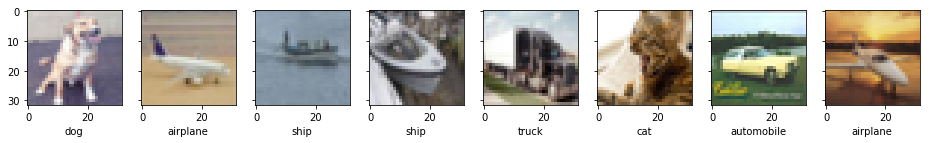

In [18]:
idxes = np.random.choice(50000,8,replace=False)
images = data_train['data'][idxes]

f, ax = plt.subplots(1,8, sharey = True, figsize=(16,2))
for i in range(8):
    ax[i].imshow(np.resize(images[i],[3,32,32]).transpose(1,2,0))
    ax[i].set_xlabel(meta_data[data_train['labels'][idxes[i]]])
plt.show()

In [5]:
class CIFAR10Dataset(Dataset):
    
    def __init__(self, data):
        self.data = data['data']
        self.labels = data['labels']
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {'data':np.resize(np.array(self.data[idx],dtype=np.float32),[3,32,32]),
                'label':self.labels[idx]}

dataset_train = CIFAR10Dataset(data_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers = 1)

dataset_test = CIFAR10Dataset(data_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers = 1)

In [57]:
class MyFirstNeuralNetwork(nn.Module):
    
    def __init__(self):
        
        super(MyFirstNeuralNetwork, self).__init__()
        
        self.filter1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 7, padding = 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        
        self.firstblock = nn.Sequential(self.filter1, self.bn1, self.relu1, self.pool1)
        
        self.filter2a = nn.Conv2d(in_channels = 32, out_channels = 128, kernel_size = 3, padding = 1)
        self.bn2a = nn.BatchNorm2d(128)
        self.relu2a = nn.ReLU()
        self.filter2b = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.bn2b = nn.BatchNorm2d(128)
        self.relu2b = nn.ReLU()
        self.filter2c = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.bn2c = nn.BatchNorm2d(128)
        self.relu2c = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.secondblock = nn.Sequential(self.filter2a, nn.Dropout2d(p=0.2), self.bn2a, self.relu2a, self.filter2b, \
                                         nn.Dropout2d(p=0.2), self.bn2b, self.relu2b, self.filter2c, \
                                         nn.Dropout2d(p=0.2), self.bn2c, self.relu2c, self.pool2)
        
        self.filter3a = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1)
        self.bn3a = nn.BatchNorm2d(256)
        self.relu3a = nn.ReLU()
        self.filter3b = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1)
        self.bn3b = nn.BatchNorm2d(256)
        self.relu3b = nn.ReLU()
        self.filter3c = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1)
        self.bn3c = nn.BatchNorm2d(256)
        self.relu3c = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = 2)
        
        self.thirdblock = nn.Sequential(self.filter3a, nn.Dropout2d(p=0.2), self.bn3a, self.relu3a, self.filter3b, \
                                         nn.Dropout2d(p=0.2), self.bn3b, self.relu3b, self.filter3c, \
                                         nn.Dropout2d(p=0.2), self.bn3c, self.relu3c, self.pool3)
        
        
        self.filter4a = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1)
        self.bn4a = nn.BatchNorm2d(512)
        self.relu4a = nn.ReLU()
        self.filter4b = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        self.bn4b = nn.BatchNorm2d(512)
        self.relu4b = nn.ReLU()
        self.filter4c = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        self.bn4c = nn.BatchNorm2d(512)
        self.relu4c = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size = 2)
        
        self.fourthblock = nn.Sequential(self.filter4a, nn.Dropout2d(p=0.2), self.bn4a, self.relu4a, self.filter4b, \
                                         nn.Dropout2d(p=0.2), self.bn4b, self.relu4b, self.filter4c, \
                                         nn.Dropout2d(p=0.2), self.bn4c, self.relu4c, self.pool4)
        
        self.fc1 = nn.Sequential(nn.Linear(2048, 1024), nn.Dropout(p=0.5), nn.BatchNorm1d(1024), nn.ReLU())
        self.classifier_head = nn.Linear(1024, 10)
    
    def forward(self, input):
        N,C,H,W = input.shape
        out = self.firstblock(input)
        out = self.secondblock(out)
        out = self.thirdblock(out)
        out = self.fourthblock(out)
        out = out.view(N,-1)
        out = self.fc1(out)
        out = self.classifier_head(out)
        
        return out
        
model = MyFirstNeuralNetwork()
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-3,weight_decay = l2_reg_parameter)

In [10]:
for epoch in range(100):

    data_train_enum = enumerate(dataloader_train)

    for step, data in data_train_enum:
        network_input = data['data']
        data_labels = data['label']

        forward_output = model.forward(network_input.cuda())

        loss = criterion(forward_output, data_labels.cuda())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step%250==0:
            model.eval()
            data_test_enum = enumerate(dataloader_test)
            accuracy = 0.0
            total_N = 0.0
            test_loss = 0.0
            for step, data in data_test_enum:
                
                network_input = data['data']
                data_labels = data['label']
                forward_output = model.forward(network_input.cuda())
                loss = criterion(forward_output.cpu(),data_labels)
                
                test_loss += loss.detach()
                
                max_value = torch.argmax(forward_output,1)
                accuracy += torch.sum((max_value == data_labels.cuda()).type(torch.FloatTensor))
                total_N += network_input.shape[0]
            
            print('Epoch: %d, Train Loss: %f, Test Loss: %f, Test Accuracy: %f'%(epoch, loss, batch_size*test_loss/total_N, accuracy/total_N))
            model.train()
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay
        



Epoch: 0, Train Loss: 2.301443, Test Loss: 2.328616, Test Accuracy: 0.100000
Epoch: 0, Train Loss: 1.984247, Test Loss: 1.785048, Test Accuracy: 0.340500
Epoch: 1, Train Loss: 2.097407, Test Loss: 1.662724, Test Accuracy: 0.395600
Epoch: 1, Train Loss: 1.510668, Test Loss: 1.420436, Test Accuracy: 0.480900
Epoch: 2, Train Loss: 1.073654, Test Loss: 1.564127, Test Accuracy: 0.430900
Epoch: 2, Train Loss: 1.363675, Test Loss: 1.400700, Test Accuracy: 0.506600
Epoch: 3, Train Loss: 1.203992, Test Loss: 1.872214, Test Accuracy: 0.354900
Epoch: 3, Train Loss: 1.702360, Test Loss: 1.240290, Test Accuracy: 0.562300
Epoch: 4, Train Loss: 1.292241, Test Loss: 1.217839, Test Accuracy: 0.560400
Epoch: 4, Train Loss: 1.364998, Test Loss: 1.379899, Test Accuracy: 0.523900
Epoch: 5, Train Loss: 0.645467, Test Loss: 1.136245, Test Accuracy: 0.599700
Epoch: 5, Train Loss: 1.354997, Test Loss: 1.229258, Test Accuracy: 0.573100
Epoch: 6, Train Loss: 1.255510, Test Loss: 1.245273, Test Accuracy: 0.555300

Epoch: 53, Train Loss: 0.540133, Test Loss: 0.525455, Test Accuracy: 0.862300
Epoch: 53, Train Loss: 0.867489, Test Loss: 0.539463, Test Accuracy: 0.859500
Epoch: 54, Train Loss: 0.457911, Test Loss: 0.529287, Test Accuracy: 0.861700
Epoch: 54, Train Loss: 0.673208, Test Loss: 0.527100, Test Accuracy: 0.860400
Epoch: 55, Train Loss: 0.654044, Test Loss: 0.529892, Test Accuracy: 0.862500
Epoch: 55, Train Loss: 0.642267, Test Loss: 0.531021, Test Accuracy: 0.861700
Epoch: 56, Train Loss: 0.571571, Test Loss: 0.529000, Test Accuracy: 0.862400
Epoch: 56, Train Loss: 0.441218, Test Loss: 0.536482, Test Accuracy: 0.861100
Epoch: 57, Train Loss: 0.550774, Test Loss: 0.530023, Test Accuracy: 0.861000
Epoch: 57, Train Loss: 0.595283, Test Loss: 0.528602, Test Accuracy: 0.862600
Epoch: 58, Train Loss: 0.291392, Test Loss: 0.528297, Test Accuracy: 0.863100
Epoch: 58, Train Loss: 0.687530, Test Loss: 0.532185, Test Accuracy: 0.861900
Epoch: 59, Train Loss: 0.706365, Test Loss: 0.531637, Test Accur

In [11]:
#We've trained a model we're happy with (hopefully!), so let's save it to disk for later use.

torch.save(model.state_dict(),'my_cifar_model.pt')

In [59]:
#If we need to load the model, we just call

model.load_state_dict(torch.load('my_cifar_model.pt'))

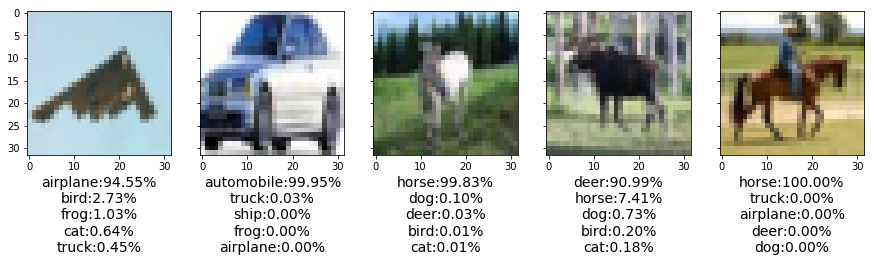

In [60]:
def get_cifar_prediction(input_image):
    #assume the input_image is 3x32x32
    
    if input_image.shape[0] != 3:
        input_image = input_image.transpose(2,0,1)
        
    input_image = np.expand_dims(input_image,0)
    input_image = torch.tensor(np.array(input_image,dtype=np.float32)).cuda()
    forward_output = model.forward(input_image).detach()
    scores = torch.softmax(forward_output,dim=1)
    prediction = torch.argmax(scores)
    
    return prediction.cpu().numpy(), scores.cpu().numpy()[0]

model.eval()
idxes = np.random.choice(10000,5)

f, ax = plt.subplots(1,5,figsize=(15,3),sharey=True)
for i in range(5):
    test_image = dataset_test[idxes[i]]['data']
    prediction,scores = get_cifar_prediction(test_image)
    max_scores_sorted = np.argsort(scores)
    ax[i].imshow(np.array(test_image,dtype=np.uint8).transpose(1,2,0))
    xlabel = '\n'.join(['%s:%.2f%%'%(meta_data[max_scores_sorted[-i]],100*scores[max_scores_sorted[-i]]) for i in range(1,6)])
    ax[i].set_xlabel(xlabel, fontsize=14)